# Generative Modeling exercises

In the first part of this notebook, we are doing the following:

1.   Clone the Git repository with the pretrained models
2.   Load necessary libraries
3.   Set up training loop
4.   Define generator and critic
5.   Train GAN
6.   Access generator performance

All the code is already written. Due to the long training times all models are pretrained. You simply have to load them. 

Then aim of the notebook is for you to get familiar with the the whole training setup in PyTorch and analyze the quality of the generated data.

Furthermore, we recommend that you think about it can be applied/adjusted to your own research. We highly recommend asking questions in this regard.

Note that the neural network classes and the training loop can be written in many different ways! This is just one way of doing it.


In [1]:
# Load libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import pdb
import numpy as np
import imageio
from google.colab import drive
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
#drive.mount('/content/gdrive',force_remount=True)
#path = 'gdrive/MyDrive/Colab Notebooks/masterclass'
#os.chdir(path)

In [3]:
!git clone https://github.com/nmucke/computational_imaging_masterclass.git

Cloning into 'computational_imaging_masterclass'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 105 (delta 16), reused 0 (delta 0), pack-reused 55
Receiving objects: 100% (105/105), 51.19 MiB | 18.88 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [4]:
# Load MNIST training data
bs = 256

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [5]:
# Train Wasserstein GAN

class TrainGAN():
    def __init__(self, generator, critic, generator_optimizer, critic_optimizer,
                 latent_dim=100, n_critic=5, gamma=10, device='cpu',
                 wasserstein=True):

        self.to_pil_image = transforms.ToPILImage()

        self.device = device
        self.generator = generator
        self.critic = critic
        self.G_opt = generator_optimizer
        self.C_opt = critic_optimizer

        self.generator.train()
        self.critic.train()

        self.latent_dim = latent_dim
        self.n_critic = n_critic
        self.gamma = gamma
        self.steps = 0
        self.fixed_z = torch.randn(64, self.latent_dim).to(self.device)

        self.wasserstein = wasserstein
        if not self.wasserstein:
          self.bce_loss = nn.BCELoss()

    def train(self, data_loader, n_epochs):
        """Train generator and critic"""

        images = []
        generator_loss = []
        critic_loss = []
        gradient_penalty = []
        for epoch in range(1, n_epochs + 1):

            # Train one step
            g_loss, c_loss, grad_penalty = self.train_epoch(data_loader)

            print(f'Epoch: {epoch}, g_loss: {g_loss:.3f},', end=' ')
            if self.wasserstein:
              print(f'c_loss: {c_loss:.3f}, grad_penalty: {grad_penalty:.3f}')
            else:
              print(f'c_loss: {c_loss:.3f}')

            # Save loss
            generator_loss.append(g_loss)
            critic_loss.append(c_loss)
            gradient_penalty.append(grad_penalty)

            # Save generated images
            generated_img = self.generator(self.fixed_z)
            generated_img = make_grid(generated_img)
            images.append(generated_img)
            self.save_generator_image(generated_img,f"outputs_WGAN/gen_img{epoch}_latent_{self.latent_dim}.png")
        
        # save the generated images as GIF file
        imgs = [np.array(self.to_pil_image(img)) for img in images]
        imageio.mimsave(f'outputs_WGAN/generator_images_latent_{self.latent_dim}.gif', imgs)

        if self.wasserstein:
          # save the generated images as GIF file
          imgs = [np.array(self.to_pil_image(img)) for img in images]
          imageio.mimsave(f'outputs_WGAN/W_generator_images_latent_{self.latent_dim}.gif', imgs)

          # Save generator and critic weights
          torch.save(self.generator.state_dict(), f'model_weights/W_generator_latent_{self.latent_dim}')
          torch.save(self.critic.state_dict(), f'model_weights/W_critic_latent_{self.latent_dim}')
        else:
          # save the generated images as GIF file
          imgs = [np.array(self.to_pil_image(img)) for img in images]
          imageio.mimsave(f'outputs_WGAN/generator_images_latent_{self.latent_dim}.gif', imgs)

          # Save generator and critic weights
          torch.save(self.generator.state_dict(), f'model_weights/generator_latent_{self.latent_dim}')
          torch.save(self.critic.state_dict(), f'model_weights/critic_latent_{self.latent_dim}')
        

        self.generator.train(mode=False)
        self.critic.train(mode=False)

        return generator_loss, critic_loss, gradient_penalty

    def train_epoch(self, data_loader):
        """Train generator and critic for one epoch"""

        for bidx, (real_data, _) in  tqdm(enumerate(data_loader),
                 total=int(len(data_loader.dataset)/data_loader.batch_size)):

            current_batch_size = len(real_data)

            real_data = real_data.to(self.device)

            c_loss, grad_penalty = self.critic_train_step(real_data)

            if bidx % self.n_critic == 0:
              g_loss = self.generator_train_step(current_batch_size)

        return g_loss, c_loss, grad_penalty

    def critic_train_step(self, data):
        """Train critic one step"""

        batch_size = data.size(0)
        generated_data = self.sample(batch_size)


        if self.wasserstein:
          grad_penalty = self.gradient_penalty(data, generated_data)
          c_loss = self.critic(generated_data).mean() - self.critic(data).mean() + grad_penalty
          grad_penalty = grad_penalty.item()
        else:
          label = torch.ones((batch_size, 1), device=self.device)
          c_loss = self.bce_loss(self.critic(data), label)

          label = torch.zeros((batch_size, 1), device=self.device)
          c_loss += self.bce_loss(self.critic(generated_data), label)

          grad_penalty = None

        self.C_opt.zero_grad()
        c_loss.backward()
        self.C_opt.step()
        
        return c_loss.item(), grad_penalty

    def generator_train_step(self, batch_size):
        """Train generator one step"""

        self.G_opt.zero_grad()
        generated_data = self.sample(batch_size)


        if self.wasserstein:
          g_loss = -self.critic(generated_data).mean()
        else:
          label = torch.ones((batch_size, 1), device=self.device)
          g_loss = self.bce_loss(self.critic(generated_data), label)

        g_loss.backward()
        self.G_opt.step()

        return g_loss.item()

    def gradient_penalty(self, data, generated_data, gamma=10):
        """Compute gradient penalty"""

        batch_size = data.size(0)
        epsilon = torch.rand(batch_size, 1, 1, 1)
        epsilon = epsilon.expand_as(data).to(self.device)

        interpolation = epsilon * data.data + (1 - epsilon) * generated_data
        interpolation = torch.autograd.Variable(interpolation, requires_grad=True)
        interpolation = interpolation.to(self.device)

        interpolation_critic_score = self.critic(interpolation)

        grad_outputs = torch.ones(interpolation_critic_score.size())
        grad_outputs = grad_outputs.to(self.device)

        gradients = torch.autograd.grad(outputs=interpolation_critic_score,
                                        inputs=interpolation,
                                        grad_outputs=grad_outputs,
                                        create_graph=True,
                                        retain_graph=None)[0]

        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
        return self.gamma * ((gradients_norm - 1) ** 2).mean()

    def sample(self, n_samples):
        """Generate n_samples fake samples"""

        z = torch.randn(n_samples, self.latent_dim).to(self.device)
        return self.generator(z)

    def save_generator_image(self, image, path):
        """Save image"""

        save_image(image, path)

In [6]:

# Define generator
class Generator(nn.Module):
    def __init__(self, latent_dim, num_out_channels=1):
        super(Generator, self).__init__()
        self.activation = nn.LeakyReLU()
        self.latent_dim = latent_dim

        # hidden_channels = [256, 128, 64, 32]
        hidden_channels = [128, 64, 32, 16]
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(latent_dim, hidden_channels[0] * 7 * 7)
        self.trans_conv1 = nn.ConvTranspose2d(
                hidden_channels[0], hidden_channels[1], kernel_size=3, stride=2,
                padding=1, output_padding=1)
        self.trans_conv1_bn = nn.BatchNorm2d(hidden_channels[1])
        self.trans_conv2 = nn.ConvTranspose2d(
                hidden_channels[1], hidden_channels[2], kernel_size=3, stride=1,
                padding=1)
        self.trans_conv2_bn = nn.BatchNorm2d(hidden_channels[2])
        self.trans_conv3 = nn.ConvTranspose2d(
                hidden_channels[2], hidden_channels[3], kernel_size=3, stride=1,
                padding=1)
        self.trans_conv3_bn = nn.BatchNorm2d(hidden_channels[3])
        self.trans_conv4 = nn.ConvTranspose2d(
                hidden_channels[3], num_out_channels, kernel_size=3, stride=2,
                padding=1, output_padding=1, bias=False)

    # forward method
    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        x = x.view(-1, self.hidden_channels[0], 7, 7)
        x = self.trans_conv1(x)
        x = self.activation(x)
        x = self.trans_conv1_bn(x)
        x = self.trans_conv2(x)
        x = self.activation(x)
        x = self.trans_conv2_bn(x)
        x = self.trans_conv3(x)
        x = self.activation(x)
        x = self.trans_conv3_bn(x)
        x = self.trans_conv4(x)
        return x


# Define critic
class Critic(nn.Module):
    def __init__(self, num_in_channels=1, wasserstein=True):
        super(Critic, self).__init__()
        self.activation = nn.LeakyReLU()

        self.wasserstein = wasserstein
        if not self.wasserstein:
            self.sigmoid = nn.Sigmoid()

        # hidden_channels = [32, 64, 128, 256]
        hidden_channels = [16, 32, 64, 128]

        self.conv0 = nn.Conv2d(num_in_channels, hidden_channels[0],
                               kernel_size=3, stride=2, padding=1)
        self.conv1 = nn.Conv2d(hidden_channels[0], hidden_channels[1],
                               kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(hidden_channels[1], hidden_channels[2],
                               kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(hidden_channels[2], hidden_channels[3],
                               kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(6272, 1, bias=False)

        # forward method

    def forward(self, x):
        x = self.conv0(x)
        x = self.activation(x)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = x.view(-1, 6272)
        x = self.fc(x)

        if self.wasserstein:
            return x
        else:
            return self.sigmoid(x)

Below, we train the GAN. You don't have to run this since the networks are already trained. 

In [ ]:

# build network
latent_dim = 10
wasserstein = True
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
critic = Critic(num_in_channels=1, wasserstein=wasserstein).to(device)

# optimizer
lr = 0.0002 
generator_optimizer = optim.RMSprop(generator.parameters(), lr = lr)
critic_optimizer = optim.RMSprop(critic.parameters(), lr = lr)

# Trainer
training_params = {
    'generator': generator,
    'critic': critic,
    'generator_optimizer': generator_optimizer, 
    'critic_optimizer': critic_optimizer,
    'latent_dim': latent_dim, 
    'n_critic': 3, 
    'gamma': 10, 
    'device': device,
    'wasserstein': wasserstein
}

trainer = TrainGAN(**training_params)

trainer.train(
  data_loader=train_loader,
  n_epochs=200
  )

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
235it [00:20, 11.30it/s]


Epoch: 1, g_loss: -13.711, c_loss: -9.755, grad_penalty: 1.249


235it [00:17, 13.64it/s]                         


Epoch: 2, g_loss: -11.318, c_loss: -8.807, grad_penalty: 1.391


235it [00:17, 13.61it/s]                         


Epoch: 3, g_loss: 2.141, c_loss: -8.847, grad_penalty: 1.250


235it [00:17, 13.73it/s]                         


Epoch: 4, g_loss: 12.092, c_loss: -8.386, grad_penalty: 1.208


235it [00:17, 13.77it/s]                         


Epoch: 5, g_loss: 11.282, c_loss: -7.450, grad_penalty: 0.957


235it [00:17, 13.36it/s]                         


Epoch: 6, g_loss: 19.779, c_loss: -6.643, grad_penalty: 0.955


235it [00:17, 13.71it/s]                         


Epoch: 7, g_loss: 16.986, c_loss: -7.108, grad_penalty: 0.586


235it [00:17, 13.72it/s]                         


Epoch: 8, g_loss: 28.740, c_loss: -6.067, grad_penalty: 0.770


235it [00:17, 13.51it/s]                         


Epoch: 9, g_loss: 19.730, c_loss: -6.109, grad_penalty: 0.575


235it [00:17, 13.62it/s]                         


Epoch: 10, g_loss: 22.939, c_loss: -6.246, grad_penalty: 0.854


235it [00:17, 13.64it/s]                         


Epoch: 11, g_loss: 31.612, c_loss: -5.707, grad_penalty: 0.695


235it [00:17, 13.52it/s]                         


Epoch: 12, g_loss: 27.764, c_loss: -6.185, grad_penalty: 0.691


235it [00:17, 13.69it/s]                         


Epoch: 13, g_loss: 36.835, c_loss: -5.381, grad_penalty: 0.613


235it [00:17, 13.75it/s]                         


Epoch: 14, g_loss: 26.289, c_loss: -5.587, grad_penalty: 0.496


235it [00:17, 13.65it/s]                         


Epoch: 15, g_loss: 29.181, c_loss: -5.723, grad_penalty: 0.688


235it [00:17, 13.67it/s]                         


Epoch: 16, g_loss: 30.867, c_loss: -5.654, grad_penalty: 0.439


235it [00:17, 13.65it/s]                         


Epoch: 17, g_loss: 33.862, c_loss: -5.357, grad_penalty: 0.548


235it [00:17, 13.54it/s]                         


Epoch: 18, g_loss: 17.779, c_loss: -5.291, grad_penalty: 0.459


235it [00:17, 13.81it/s]                         


Epoch: 19, g_loss: 29.585, c_loss: -5.309, grad_penalty: 0.554


235it [00:17, 13.57it/s]                         


Epoch: 20, g_loss: 18.980, c_loss: -5.670, grad_penalty: 0.474


235it [00:17, 13.48it/s]                         


Epoch: 21, g_loss: 23.686, c_loss: -5.417, grad_penalty: 0.600


235it [00:17, 13.69it/s]                         


Epoch: 22, g_loss: 30.755, c_loss: -4.653, grad_penalty: 0.537


235it [00:17, 13.66it/s]                         


Epoch: 23, g_loss: 30.279, c_loss: -5.034, grad_penalty: 0.499


235it [00:17, 13.65it/s]                         


Epoch: 24, g_loss: 26.310, c_loss: -4.986, grad_penalty: 0.753


235it [00:17, 13.56it/s]                         


Epoch: 25, g_loss: 30.145, c_loss: -4.721, grad_penalty: 0.377


235it [00:17, 13.66it/s]                         


Epoch: 26, g_loss: 22.197, c_loss: -5.240, grad_penalty: 0.488


235it [00:17, 13.75it/s]                         


Epoch: 27, g_loss: 21.679, c_loss: -5.261, grad_penalty: 0.655


235it [00:17, 13.67it/s]                         


Epoch: 28, g_loss: 20.352, c_loss: -5.120, grad_penalty: 0.610


235it [00:17, 13.66it/s]                         


Epoch: 29, g_loss: 19.561, c_loss: -4.842, grad_penalty: 0.415


235it [00:17, 13.50it/s]                         


Epoch: 30, g_loss: 16.694, c_loss: -4.651, grad_penalty: 0.590


235it [00:17, 13.47it/s]                         


Epoch: 31, g_loss: 20.984, c_loss: -4.728, grad_penalty: 0.454


235it [00:17, 13.57it/s]                         


Epoch: 32, g_loss: 25.003, c_loss: -3.718, grad_penalty: 0.665


235it [00:17, 13.72it/s]                         


Epoch: 33, g_loss: 10.130, c_loss: -4.769, grad_penalty: 0.548


235it [00:17, 13.65it/s]                         


Epoch: 34, g_loss: 22.620, c_loss: -4.679, grad_penalty: 0.348


235it [00:17, 13.54it/s]                         


Epoch: 35, g_loss: 8.886, c_loss: -4.564, grad_penalty: 0.578


235it [00:17, 13.58it/s]                         


Epoch: 36, g_loss: 18.082, c_loss: -4.807, grad_penalty: 0.508


235it [00:17, 13.56it/s]                         


Epoch: 37, g_loss: 24.008, c_loss: -4.418, grad_penalty: 0.509


235it [00:17, 13.74it/s]                         


Epoch: 38, g_loss: 14.143, c_loss: -4.325, grad_penalty: 0.495


235it [00:17, 13.54it/s]                         


Epoch: 39, g_loss: 19.924, c_loss: -4.535, grad_penalty: 0.409


235it [00:17, 13.52it/s]                         


Epoch: 40, g_loss: 15.056, c_loss: -4.474, grad_penalty: 0.604


235it [00:17, 13.70it/s]                         


Epoch: 41, g_loss: 14.298, c_loss: -4.272, grad_penalty: 0.492


235it [00:17, 13.75it/s]                         


Epoch: 42, g_loss: 15.065, c_loss: -4.101, grad_penalty: 0.586


235it [00:17, 13.68it/s]                         


Epoch: 43, g_loss: 7.601, c_loss: -4.404, grad_penalty: 0.394


235it [00:17, 13.48it/s]                         


Epoch: 44, g_loss: 9.072, c_loss: -4.656, grad_penalty: 0.432


235it [00:17, 13.61it/s]                         


Epoch: 45, g_loss: 20.289, c_loss: -4.295, grad_penalty: 0.478


235it [00:17, 13.50it/s]                         


Epoch: 46, g_loss: 13.186, c_loss: -4.067, grad_penalty: 0.377


235it [00:17, 13.74it/s]                         


Epoch: 47, g_loss: 9.878, c_loss: -4.130, grad_penalty: 0.425


235it [00:17, 13.61it/s]                         


Epoch: 48, g_loss: 12.848, c_loss: -4.397, grad_penalty: 0.268


235it [00:17, 13.49it/s]                         


Epoch: 49, g_loss: 11.326, c_loss: -4.195, grad_penalty: 0.559


235it [00:17, 13.61it/s]                         


Epoch: 50, g_loss: 16.798, c_loss: -3.842, grad_penalty: 0.461


235it [00:17, 13.69it/s]                         


Epoch: 51, g_loss: 13.386, c_loss: -4.034, grad_penalty: 0.369


235it [00:17, 13.59it/s]                         


Epoch: 52, g_loss: 12.184, c_loss: -4.026, grad_penalty: 0.431


235it [00:17, 13.69it/s]                         


Epoch: 53, g_loss: 14.792, c_loss: -4.016, grad_penalty: 0.645


235it [00:17, 13.71it/s]                         


Epoch: 54, g_loss: 9.084, c_loss: -3.701, grad_penalty: 0.401


235it [00:17, 13.61it/s]                         


Epoch: 55, g_loss: 8.383, c_loss: -3.923, grad_penalty: 0.414


235it [00:17, 13.82it/s]                         


Epoch: 56, g_loss: 14.222, c_loss: -3.757, grad_penalty: 0.568


235it [00:17, 13.66it/s]                         


Epoch: 57, g_loss: 7.549, c_loss: -3.590, grad_penalty: 0.435


235it [00:17, 13.53it/s]                         


Epoch: 58, g_loss: 11.952, c_loss: -3.993, grad_penalty: 0.334


235it [00:17, 13.63it/s]                         


Epoch: 59, g_loss: 12.057, c_loss: -3.830, grad_penalty: 0.447


235it [00:17, 13.69it/s]                         


Epoch: 60, g_loss: 6.014, c_loss: -3.952, grad_penalty: 0.408


235it [00:17, 13.66it/s]                         


Epoch: 61, g_loss: 8.491, c_loss: -3.671, grad_penalty: 0.317


235it [00:17, 13.68it/s]                         


Epoch: 62, g_loss: 8.747, c_loss: -3.892, grad_penalty: 0.414


235it [00:17, 13.68it/s]                         


Epoch: 63, g_loss: 12.012, c_loss: -3.755, grad_penalty: 0.423


235it [00:17, 13.68it/s]                         


Epoch: 64, g_loss: 6.770, c_loss: -3.789, grad_penalty: 0.368


235it [00:17, 13.64it/s]                         


Epoch: 65, g_loss: 12.819, c_loss: -3.844, grad_penalty: 0.380


235it [00:17, 13.56it/s]                         


Epoch: 66, g_loss: 13.203, c_loss: -4.052, grad_penalty: 0.305


235it [00:17, 13.69it/s]                         


Epoch: 67, g_loss: 5.301, c_loss: -3.435, grad_penalty: 0.351


235it [00:17, 13.67it/s]                         


Epoch: 68, g_loss: 8.110, c_loss: -3.382, grad_penalty: 0.382


235it [00:17, 13.61it/s]                         


Epoch: 69, g_loss: 6.057, c_loss: -3.548, grad_penalty: 0.290


235it [00:17, 13.75it/s]                         


Epoch: 70, g_loss: 7.746, c_loss: -3.815, grad_penalty: 0.306


235it [00:17, 13.56it/s]                         


Epoch: 71, g_loss: 6.798, c_loss: -3.712, grad_penalty: 0.301


235it [00:17, 13.63it/s]                         


Epoch: 72, g_loss: 7.285, c_loss: -3.742, grad_penalty: 0.469


235it [00:17, 13.64it/s]                         


Epoch: 73, g_loss: 8.955, c_loss: -3.835, grad_penalty: 0.396


235it [00:17, 13.66it/s]                         


Epoch: 74, g_loss: 11.226, c_loss: -3.225, grad_penalty: 0.386


235it [00:17, 13.64it/s]                         


Epoch: 75, g_loss: 2.854, c_loss: -3.666, grad_penalty: 0.341


235it [00:17, 13.56it/s]                         


Epoch: 76, g_loss: 13.004, c_loss: -3.724, grad_penalty: 0.330


235it [00:17, 13.64it/s]                         


Epoch: 77, g_loss: 11.031, c_loss: -3.930, grad_penalty: 0.375


235it [00:17, 13.64it/s]                         


Epoch: 78, g_loss: 4.943, c_loss: -3.487, grad_penalty: 0.483


235it [00:17, 13.60it/s]                         


Epoch: 79, g_loss: 2.718, c_loss: -3.979, grad_penalty: 0.353


235it [00:17, 13.66it/s]                         


Epoch: 80, g_loss: 10.727, c_loss: -3.479, grad_penalty: 0.328


235it [00:17, 13.59it/s]                         


Epoch: 81, g_loss: 13.006, c_loss: -3.330, grad_penalty: 0.366


235it [00:17, 13.69it/s]                         


Epoch: 82, g_loss: 8.804, c_loss: -3.555, grad_penalty: 0.239


235it [00:17, 13.58it/s]                         


Epoch: 83, g_loss: 10.322, c_loss: -3.308, grad_penalty: 0.338


235it [00:17, 13.72it/s]                         


Epoch: 84, g_loss: 4.425, c_loss: -3.375, grad_penalty: 0.332


235it [00:17, 13.49it/s]                         


Epoch: 85, g_loss: 7.393, c_loss: -3.067, grad_penalty: 0.391


235it [00:17, 13.68it/s]                         


Epoch: 86, g_loss: 6.150, c_loss: -3.567, grad_penalty: 0.329


235it [00:17, 13.61it/s]                         


Epoch: 87, g_loss: 12.808, c_loss: -3.286, grad_penalty: 0.498


235it [00:17, 13.70it/s]                         


Epoch: 88, g_loss: 4.760, c_loss: -3.038, grad_penalty: 0.335


235it [00:17, 13.53it/s]                         


Epoch: 89, g_loss: 12.240, c_loss: -3.091, grad_penalty: 0.462


235it [00:17, 13.65it/s]                         


Epoch: 90, g_loss: 15.096, c_loss: -3.686, grad_penalty: 0.244


235it [00:17, 13.75it/s]                         


Epoch: 91, g_loss: 4.983, c_loss: -3.464, grad_penalty: 0.226


235it [00:17, 13.59it/s]                         


Epoch: 92, g_loss: 8.422, c_loss: -3.424, grad_penalty: 0.437


235it [00:17, 13.71it/s]                         


Epoch: 93, g_loss: 12.580, c_loss: -3.337, grad_penalty: 0.344


235it [00:17, 13.49it/s]                         


Epoch: 94, g_loss: 11.026, c_loss: -3.342, grad_penalty: 0.430


235it [00:17, 13.45it/s]                         


Epoch: 95, g_loss: 11.890, c_loss: -3.078, grad_penalty: 0.291


235it [00:17, 13.56it/s]                         


Epoch: 96, g_loss: 10.178, c_loss: -3.649, grad_penalty: 0.303


235it [00:17, 13.74it/s]                         


Epoch: 97, g_loss: 11.836, c_loss: -3.267, grad_penalty: 0.293


235it [00:17, 13.56it/s]                         


Epoch: 98, g_loss: 8.191, c_loss: -3.283, grad_penalty: 0.260


235it [00:17, 13.44it/s]                         


Epoch: 99, g_loss: 12.578, c_loss: -3.352, grad_penalty: 0.341


235it [00:17, 13.66it/s]                         


Epoch: 100, g_loss: 6.246, c_loss: -3.865, grad_penalty: 0.454


235it [00:17, 13.61it/s]                         


Epoch: 101, g_loss: 9.230, c_loss: -3.450, grad_penalty: 0.311


235it [00:17, 13.71it/s]                         


Epoch: 102, g_loss: 5.314, c_loss: -3.418, grad_penalty: 0.376


235it [00:17, 13.51it/s]                         


Epoch: 103, g_loss: 10.552, c_loss: -3.132, grad_penalty: 0.265


235it [00:17, 13.59it/s]                         


Epoch: 104, g_loss: 13.489, c_loss: -2.836, grad_penalty: 0.507


235it [00:17, 13.36it/s]                         


Epoch: 105, g_loss: 10.727, c_loss: -3.138, grad_penalty: 0.241


235it [00:17, 13.66it/s]                         


Epoch: 106, g_loss: 5.386, c_loss: -3.287, grad_penalty: 0.278


235it [00:17, 13.70it/s]                         


Epoch: 107, g_loss: 7.573, c_loss: -2.868, grad_penalty: 0.344


235it [00:17, 13.49it/s]                         


Epoch: 108, g_loss: 10.848, c_loss: -3.366, grad_penalty: 0.191


235it [00:17, 13.48it/s]                         


Epoch: 109, g_loss: 13.670, c_loss: -2.577, grad_penalty: 0.361


235it [00:17, 13.67it/s]                         


Epoch: 110, g_loss: 10.206, c_loss: -3.271, grad_penalty: 0.241


235it [00:17, 13.68it/s]                         


Epoch: 111, g_loss: 13.564, c_loss: -2.906, grad_penalty: 0.353


235it [00:17, 13.61it/s]                         


Epoch: 112, g_loss: 5.526, c_loss: -3.329, grad_penalty: 0.322


235it [00:17, 13.51it/s]                         


Epoch: 113, g_loss: 11.729, c_loss: -2.655, grad_penalty: 0.293


235it [00:17, 13.54it/s]                         


Epoch: 114, g_loss: 10.120, c_loss: -3.389, grad_penalty: 0.341


235it [00:17, 13.53it/s]                         


Epoch: 115, g_loss: 8.298, c_loss: -3.230, grad_penalty: 0.310


235it [00:22, 10.40it/s]                         


Epoch: 116, g_loss: 7.495, c_loss: -3.442, grad_penalty: 0.354


235it [00:27,  8.40it/s]


Epoch: 117, g_loss: 7.535, c_loss: -3.045, grad_penalty: 0.271


235it [00:24,  9.65it/s]


Epoch: 118, g_loss: 11.387, c_loss: -2.566, grad_penalty: 0.399


235it [00:17, 13.56it/s]                         


Epoch: 119, g_loss: 13.797, c_loss: -3.353, grad_penalty: 0.283


235it [00:17, 13.55it/s]                         


Epoch: 120, g_loss: 7.736, c_loss: -3.441, grad_penalty: 0.303


235it [00:17, 13.33it/s]


Epoch: 121, g_loss: 4.637, c_loss: -2.846, grad_penalty: 0.414


235it [00:17, 13.43it/s]


Epoch: 122, g_loss: 12.842, c_loss: -2.421, grad_penalty: 0.383


235it [00:17, 13.66it/s]                         


Epoch: 123, g_loss: 13.346, c_loss: -2.944, grad_penalty: 0.275


235it [00:17, 13.36it/s]                         


Epoch: 124, g_loss: 11.204, c_loss: -3.048, grad_penalty: 0.320


235it [00:17, 13.56it/s]                         


Epoch: 125, g_loss: 15.785, c_loss: -2.895, grad_penalty: 0.236


235it [00:17, 13.63it/s]                         


Epoch: 126, g_loss: 11.260, c_loss: -2.934, grad_penalty: 0.291


235it [00:17, 13.52it/s]                         


Epoch: 127, g_loss: 9.067, c_loss: -3.331, grad_penalty: 0.270


235it [00:17, 13.54it/s]                         


Epoch: 128, g_loss: 11.689, c_loss: -3.035, grad_penalty: 0.291


235it [00:17, 13.72it/s]                         


Epoch: 129, g_loss: 14.376, c_loss: -3.307, grad_penalty: 0.327


235it [00:17, 13.18it/s]                         


Epoch: 130, g_loss: 13.175, c_loss: -3.123, grad_penalty: 0.216


235it [00:17, 13.63it/s]                         


Epoch: 131, g_loss: 16.953, c_loss: -2.904, grad_penalty: 0.172


235it [00:17, 13.69it/s]                         


Epoch: 132, g_loss: 4.292, c_loss: -2.748, grad_penalty: 0.340


235it [00:17, 13.63it/s]                         


Epoch: 133, g_loss: 8.795, c_loss: -2.689, grad_penalty: 0.298


235it [00:17, 13.61it/s]                         


Epoch: 134, g_loss: 9.298, c_loss: -3.133, grad_penalty: 0.427


235it [00:17, 13.66it/s]                         


Epoch: 135, g_loss: 7.763, c_loss: -2.492, grad_penalty: 0.275


235it [00:17, 13.49it/s]                         


Epoch: 136, g_loss: 12.738, c_loss: -2.941, grad_penalty: 0.322


235it [00:17, 13.64it/s]                         


Epoch: 137, g_loss: 11.981, c_loss: -2.851, grad_penalty: 0.173


235it [00:17, 13.62it/s]                         


Epoch: 138, g_loss: 11.843, c_loss: -3.268, grad_penalty: 0.316


235it [00:17, 13.47it/s]                         


Epoch: 139, g_loss: 9.815, c_loss: -3.429, grad_penalty: 0.439


235it [00:17, 13.51it/s]                         


Epoch: 140, g_loss: 11.670, c_loss: -3.043, grad_penalty: 0.267


235it [00:17, 13.56it/s]                         


Epoch: 141, g_loss: 8.749, c_loss: -2.871, grad_penalty: 0.268


235it [00:17, 13.62it/s]                         


Epoch: 142, g_loss: 8.515, c_loss: -2.904, grad_penalty: 0.386


235it [00:17, 13.55it/s]                         


Epoch: 143, g_loss: 12.458, c_loss: -2.780, grad_penalty: 0.321


235it [00:17, 13.58it/s]                         


Epoch: 144, g_loss: 11.250, c_loss: -2.919, grad_penalty: 0.365


235it [00:17, 13.54it/s]                         


Epoch: 145, g_loss: 12.143, c_loss: -2.655, grad_penalty: 0.244


235it [00:17, 13.70it/s]                         


Epoch: 146, g_loss: 17.328, c_loss: -2.089, grad_penalty: 0.328


235it [00:17, 13.57it/s]                         


Epoch: 147, g_loss: 11.897, c_loss: -2.704, grad_penalty: 0.271


235it [00:17, 13.47it/s]                         


Epoch: 148, g_loss: 10.274, c_loss: -2.532, grad_penalty: 0.385


235it [00:17, 13.36it/s]                         


Epoch: 149, g_loss: 18.035, c_loss: -2.794, grad_penalty: 0.327


235it [00:17, 13.62it/s]                         


Epoch: 150, g_loss: 4.740, c_loss: -2.807, grad_penalty: 0.276


235it [00:17, 13.63it/s]                         


Epoch: 151, g_loss: 6.366, c_loss: -2.842, grad_penalty: 0.203


235it [00:17, 13.52it/s]                         


Epoch: 152, g_loss: 10.388, c_loss: -3.256, grad_penalty: 0.301


235it [00:17, 13.59it/s]                         


Epoch: 153, g_loss: 12.153, c_loss: -2.361, grad_penalty: 0.375


235it [00:17, 13.56it/s]                         


Epoch: 154, g_loss: 12.418, c_loss: -2.684, grad_penalty: 0.233


235it [00:17, 13.66it/s]                         


Epoch: 155, g_loss: 11.908, c_loss: -2.479, grad_penalty: 0.307


235it [00:17, 13.69it/s]                         


Epoch: 156, g_loss: 11.492, c_loss: -2.942, grad_penalty: 0.208


235it [00:17, 13.52it/s]                         


Epoch: 157, g_loss: 2.905, c_loss: -2.572, grad_penalty: 0.258


235it [00:17, 13.55it/s]                         


Epoch: 158, g_loss: 10.576, c_loss: -2.601, grad_penalty: 0.189


235it [00:17, 13.51it/s]                         


Epoch: 159, g_loss: 5.550, c_loss: -2.506, grad_penalty: 0.245


235it [00:17, 13.72it/s]                         


Epoch: 160, g_loss: 10.464, c_loss: -2.657, grad_penalty: 0.208


235it [00:17, 13.51it/s]                         


Epoch: 161, g_loss: 7.502, c_loss: -3.041, grad_penalty: 0.310


235it [00:17, 13.59it/s]                         


Epoch: 162, g_loss: 13.508, c_loss: -2.802, grad_penalty: 0.188


235it [00:17, 13.62it/s]                         


Epoch: 163, g_loss: 11.020, c_loss: -2.441, grad_penalty: 0.253


235it [00:17, 13.57it/s]                         


Epoch: 164, g_loss: 4.210, c_loss: -2.637, grad_penalty: 0.220


235it [00:17, 13.65it/s]                         


Epoch: 165, g_loss: 11.955, c_loss: -2.529, grad_penalty: 0.226


235it [00:17, 13.63it/s]                         


Epoch: 166, g_loss: 11.387, c_loss: -2.299, grad_penalty: 0.219


235it [00:17, 13.56it/s]                         


Epoch: 167, g_loss: 10.274, c_loss: -3.111, grad_penalty: 0.354


235it [00:17, 13.62it/s]                         


Epoch: 168, g_loss: 7.664, c_loss: -2.702, grad_penalty: 0.211


235it [00:17, 13.63it/s]                         


Epoch: 169, g_loss: 11.367, c_loss: -2.733, grad_penalty: 0.325


235it [00:17, 13.68it/s]                         


Epoch: 170, g_loss: 10.061, c_loss: -2.789, grad_penalty: 0.259


235it [00:17, 13.68it/s]                         


Epoch: 171, g_loss: 7.759, c_loss: -2.714, grad_penalty: 0.300


235it [00:17, 13.52it/s]                         


Epoch: 172, g_loss: 10.877, c_loss: -2.763, grad_penalty: 0.299


235it [00:17, 13.54it/s]                         


Epoch: 173, g_loss: 12.411, c_loss: -2.541, grad_penalty: 0.260


235it [00:17, 13.71it/s]                         


Epoch: 174, g_loss: 8.485, c_loss: -3.035, grad_penalty: 0.276


235it [00:17, 13.38it/s]                         


Epoch: 175, g_loss: 10.874, c_loss: -2.612, grad_penalty: 0.282


235it [00:17, 13.45it/s]                         


Epoch: 176, g_loss: 10.686, c_loss: -2.628, grad_penalty: 0.257


235it [00:17, 13.65it/s]                         


Epoch: 177, g_loss: 5.655, c_loss: -2.730, grad_penalty: 0.342


235it [00:17, 13.69it/s]                         


Epoch: 178, g_loss: 10.138, c_loss: -2.999, grad_penalty: 0.193


235it [00:17, 13.59it/s]                         


Epoch: 179, g_loss: 7.360, c_loss: -2.399, grad_penalty: 0.314


235it [00:17, 13.68it/s]                         


Epoch: 180, g_loss: 6.423, c_loss: -2.843, grad_penalty: 0.230


235it [00:17, 13.39it/s]                         


Epoch: 181, g_loss: 8.278, c_loss: -2.544, grad_penalty: 0.228


235it [00:17, 13.53it/s]                         


Epoch: 182, g_loss: 7.319, c_loss: -2.539, grad_penalty: 0.220


235it [00:17, 13.72it/s]                         


Epoch: 183, g_loss: 9.864, c_loss: -2.528, grad_penalty: 0.259


235it [00:17, 13.53it/s]                         


Epoch: 184, g_loss: 6.048, c_loss: -2.563, grad_penalty: 0.219


235it [00:17, 13.45it/s]                         


Epoch: 185, g_loss: 8.581, c_loss: -2.540, grad_penalty: 0.295


235it [00:17, 13.64it/s]                         


Epoch: 186, g_loss: 7.021, c_loss: -2.874, grad_penalty: 0.274


235it [00:17, 13.64it/s]                         


Epoch: 187, g_loss: 9.273, c_loss: -2.552, grad_penalty: 0.218


235it [00:17, 13.69it/s]                         


Epoch: 188, g_loss: 11.960, c_loss: -2.200, grad_penalty: 0.264


235it [00:17, 13.69it/s]                         


Epoch: 189, g_loss: 12.383, c_loss: -2.779, grad_penalty: 0.211


235it [00:17, 13.50it/s]                         


Epoch: 190, g_loss: 10.615, c_loss: -2.469, grad_penalty: 0.334


235it [00:17, 13.65it/s]                         


Epoch: 191, g_loss: 10.385, c_loss: -2.399, grad_penalty: 0.221


235it [00:17, 13.62it/s]                         


Epoch: 192, g_loss: 10.459, c_loss: -2.386, grad_penalty: 0.174


235it [00:17, 13.64it/s]                         


Epoch: 193, g_loss: 4.900, c_loss: -1.915, grad_penalty: 0.244


235it [00:17, 13.47it/s]                         


Epoch: 194, g_loss: 4.845, c_loss: -2.472, grad_penalty: 0.200


235it [00:17, 13.55it/s]                         


Epoch: 195, g_loss: 9.928, c_loss: -2.538, grad_penalty: 0.245


235it [00:17, 13.63it/s]                         


Epoch: 196, g_loss: 12.047, c_loss: -2.968, grad_penalty: 0.204


235it [00:17, 13.67it/s]                         


Epoch: 197, g_loss: 13.966, c_loss: -2.359, grad_penalty: 0.285


235it [00:17, 13.57it/s]                         


Epoch: 198, g_loss: 9.361, c_loss: -2.576, grad_penalty: 0.277


235it [00:17, 13.42it/s]                         


Epoch: 199, g_loss: 10.069, c_loss: -2.560, grad_penalty: 0.211


235it [00:17, 13.61it/s]                         


Epoch: 200, g_loss: 6.717, c_loss: -2.435, grad_penalty: 0.275


([-13.711077690124512,
  -11.317721366882324,
  2.140888214111328,
  12.091781616210938,
  11.282318115234375,
  19.779273986816406,
  16.986299514770508,
  28.740482330322266,
  19.730350494384766,
  22.938901901245117,
  31.611724853515625,
  27.764293670654297,
  36.83488845825195,
  26.289432525634766,
  29.181407928466797,
  30.866575241088867,
  33.86199188232422,
  17.779361724853516,
  29.584951400756836,
  18.980361938476562,
  23.685773849487305,
  30.754531860351562,
  30.27899169921875,
  26.30964469909668,
  30.144893646240234,
  22.197439193725586,
  21.67904281616211,
  20.351980209350586,
  19.560829162597656,
  16.693653106689453,
  20.984447479248047,
  25.002635955810547,
  10.130306243896484,
  22.620168685913086,
  8.885658264160156,
  18.081811904907227,
  24.008146286010742,
  14.142745018005371,
  19.923986434936523,
  15.056078910827637,
  14.29833984375,
  15.064905166625977,
  7.600771903991699,
  9.072282791137695,
  20.28857421875,
  13.186263084411621,
  9

Below, you can see a comparison of the vanilla and Wasserstein GANs for various latent space sizes.

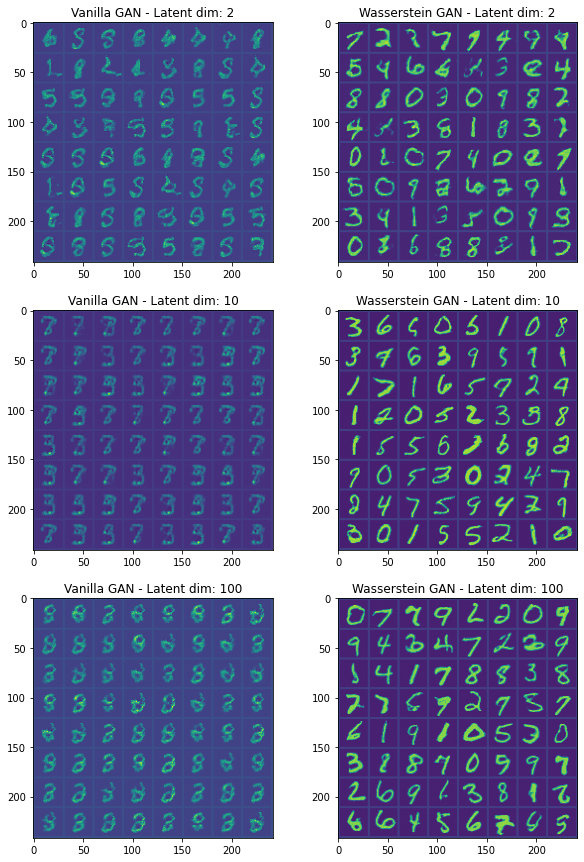

In [7]:

# Define latent space samples
n_samples = 64

plt.figure(figsize=(10,15))
for i, latent_dim in enumerate([2, 10, 100]):
  z = torch.randn(n_samples, latent_dim).to(device)

  # Compute vanilla GAN samples
  vanilla_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
  vanilla_state_dict_path = f'computational_imaging_masterclass/generator_latent_{latent_dim}'
  state_dict = torch.load(vanilla_state_dict_path, map_location=device)
  vanilla_generator.load_state_dict(state_dict)
  vanilla_generator.eval()
  vanilla_generated_img = vanilla_generator(z)
  vanilla_generated_img = make_grid(vanilla_generated_img)[0:1]
  vanilla_generated_img = vanilla_generated_img.detach().cpu().numpy()

  # Compute Wasserstein GAN samples
  wasserstein_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
  wasserstein_state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
  state_dict = torch.load(wasserstein_state_dict_path, map_location=device)
  wasserstein_generator.load_state_dict(state_dict)
  wasserstein_generator.eval()
  wasserstein_generated_img = wasserstein_generator(z)
  wasserstein_generated_img = make_grid(wasserstein_generated_img)[0:1]
  wasserstein_generated_img = wasserstein_generated_img.detach().cpu().numpy()

  # Plotting
  plt.subplot(3,2,2*(i+1)-1)
  plt.imshow(vanilla_generated_img[0])
  plt.title(f'Vanilla GAN - Latent dim: {latent_dim}')
  plt.subplot(3,2,2*(i+1))
  plt.imshow(wasserstein_generated_img[0])
  plt.title(f'Wasserstein GAN - Latent dim: {latent_dim}')
plt.show()




Below, you can see how the GANs interpolate a 2-dimensional latent space. Think about what it means to "interpolate the latent space". Does the output make sense?

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


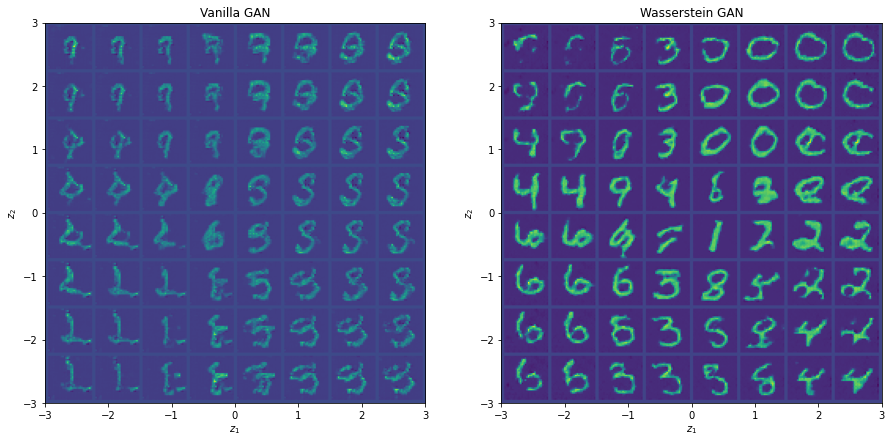

In [8]:
# Set up latent space samples on a grid
latent_dim = 2
num_samples = 8
z_lim = torch.linspace(-3, 3, num_samples)
z_x, z_y = torch.meshgrid(z_lim, z_lim)
z_x, z_y = z_x.flatten(), z_y.flatten()
z = torch.stack([z_x, z_y], dim=1).to(device)

# Load and evaluate vanilla GAN
vanilla_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
vanilla_state_dict_path = f'computational_imaging_masterclass/generator_latent_{latent_dim}'
state_dict = torch.load(vanilla_state_dict_path, map_location=device)
vanilla_generator.load_state_dict(state_dict)
vanilla_generator.eval()
vanilla_generated_img = vanilla_generator(z)
vanilla_generated_img = make_grid(vanilla_generated_img)[0:1]
vanilla_generated_img = vanilla_generated_img.detach().cpu().numpy()

# Load and evaluate Wasserstein GAN
wasserstein_generator = Generator(latent_dim = latent_dim, num_out_channels = 1).to(device)
wasserstein_state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
state_dict = torch.load(wasserstein_state_dict_path, map_location=device)
wasserstein_generator.load_state_dict(state_dict)
wasserstein_generator.eval()
wasserstein_generated_img = wasserstein_generator(z)
wasserstein_generated_img = make_grid(wasserstein_generated_img)[0:1]
wasserstein_generated_img = wasserstein_generated_img.detach().cpu().numpy()

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(vanilla_generated_img[0], extent=[z_lim[0], z_lim[-1], z_lim[0], z_lim[-1]])
plt.title('Vanilla GAN')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.subplot(1,2,2)
plt.imshow(wasserstein_generated_img[0], extent=[z_lim[0], z_lim[-1], z_lim[0], z_lim[-1]])
plt.title('Wasserstein GAN')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()

# Inverse Problems with GANs

In this section we see how the MCGAN approach can be used to solve inverse problems.


All the code is written, so you just have to play around with it. 

We recommend trying different kind of noise distributions and observation operators.

Again, think about how this can be applied to your own research

In [9]:
# Install Hamiltorch - Hamiltonian monte carlo library
!pip install git+https://github.com/AdamCobb/hamiltorch

  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-auzqglr7
  Running command git clone -q https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-auzqglr7
  Created wheel for hamiltorch: filename=hamiltorch-0.4.0.dev1-py3-none-any.whl size=20130 sha256=84e54014b0657edb71fc3488cabc50b19d180ebf197eb9494984a35da9353418
  Stored in directory: /tmp/pip-ephem-wheel-cache-eky9ouin/wheels/94/33/56/4cf57b40759f68de688e5e01bee26d036f98048a16a9733e9b
Successfully built hamiltorch


In [10]:
# All the necessary routines for solving the Bayesian inverse problems 
# with the MCGAN approach

import hamiltorch

def observation_operator(data, obs_idx):
  """Observation operator"""
  
  return data[0, obs_idx[0], obs_idx[1]]

def latent_posterior(z, generator, obs_operator, observations,
                     prior_mean, prior_std, noise_mean, noise_std):
  """Latent space log-posterior"""

  log_prior = torch.distributions.Normal(
      prior_mean,
      prior_std
      ).log_prob(z).sum()

  gen_state = generator(z.view(1, latent_dim))[0]
  gen_state = obs_operator(gen_state)
  error = observations - gen_state

  log_likelihood = torch.distributions.Normal(
      noise_mean,
      noise_std
      ).log_prob(error).sum()

  return log_prior + log_likelihood


def compute_MAP(z, num_iters, posterior):
  """Compute maximum a posteriori estimate"""

  optimizer = optim.Adam([z], lr=1e-2)

  pbar = tqdm(range(num_iters), mininterval=3.,postfix=['Loss', dict(loss="0")])
  for epoch in pbar:

    optimizer.zero_grad()

    neg_log_prob = -posterior(z)

    neg_log_prob.backward()
    optimizer.step()

    pbar.postfix[1] = f"{neg_log_prob.item():.3f}"

  return z

def hamiltonian_MC(z_init,posterior, HMC_params):
  """Compute Hamiltonian Monte Carlo latent space samples"""

  z_samples = hamiltorch.sample(log_prob_func=posterior,
                                params_init=z_init,
                                **HMC_params)
  return torch.stack(z_samples)

Run the code below to solve inverse problem. Think about the result. 
- Does the standard uncertainty make sense?
- How does increasing the noise affect the result?
- How does changing the observation operator affect the result?
- What happens when you change the latent space dimension?
- Is there a difference between the MAP and the MCMC estimation? If so, why? 

/usr/local/lib/python3.7/dist-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 7500/7500 [00:36<00:00, 203.42it/s['Loss', '3558.724']]

Sampling (Sampler.HMC; Integrator.IMPLICIT)


Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.0024495888501405716

Acceptance Rate 0.29


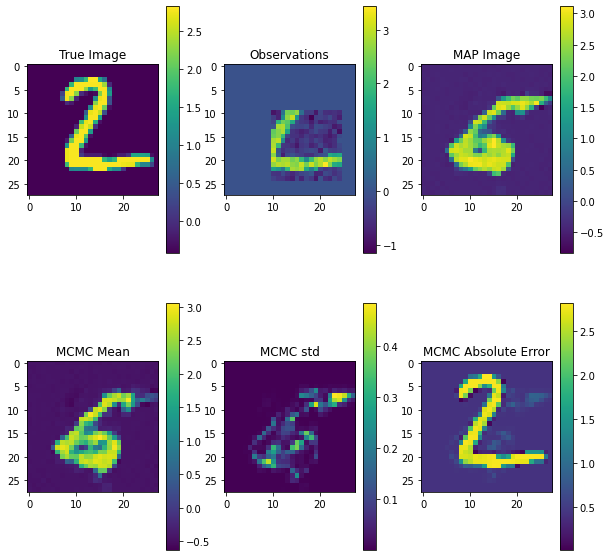

In [13]:

latent_dim = 100

generator = Generator(latent_dim=latent_dim, num_out_channels=1).to(device)
state_dict_path = f'computational_imaging_masterclass/W_generator_latent_{latent_dim}'
state_dict = torch.load(state_dict_path, map_location=device)
generator.load_state_dict(state_dict)
generator.eval()

# Load a test image
test_case = 123
test_image = test_dataset[test_case][0]

# Define observation pixels
# Choose which pixels are being used for observations
obs_x, obs_y = torch.meshgrid(torch.arange(10,25), torch.arange(10,25))
obs_idx = [obs_x.flatten(), obs_y.flatten()]
obs_operator = lambda x: observation_operator(x, obs_idx)

test_observations = obs_operator(test_image)

# Set artificial noise mean and variance
# Choose the level of noise
noise_mean = 0.
noise_std = 0.25

# Sample noise from a normal distribution
noise = torch.distributions.Normal(
        noise_mean,
        noise_std
        ).sample_n(len(test_observations.flatten()))

# Add noise to the observations
test_observations += noise.view(test_observations.shape)
test_observations = test_observations.to(device)

# Set posterior parameters
posterior_params = {
    'generator': generator,
    'obs_operator': obs_operator,
    'observations': test_observations,
    'prior_mean': torch.zeros(latent_dim, device=device),
    'prior_std': torch.ones(latent_dim, device=device),
    'noise_mean': noise_mean,
    'noise_std': noise_std
    }
  
# Set Hamiltonian MC parameters
num_samples = 2500
num_burn = num_samples
HMC_params = {
    'num_samples': num_samples+num_burn,
    'step_size': 1.,
    'num_steps_per_sample': 5,
    'burn': num_burn,
    'integrator': hamiltorch.Integrator.IMPLICIT,
    'sampler': hamiltorch.Sampler.HMC_NUTS,
    'desired_accept_rate': 0.3
    }

# Define log posterior as a function of only the latent space
log_posterior = lambda z: latent_posterior(z, **posterior_params)

# Choose initial latent sample
z = torch.randn(1, latent_dim, requires_grad=True, device=device)

# Compute maximum a posteriori latent estimate
z_MAP = compute_MAP(
    z=z, 
    num_iters=7500,
    posterior=log_posterior
    )

# Generate full order posterior MAP from latent MAP
gen_MAP = generator(z_MAP)[0].detach().cpu()

# Latent space posterior samples with HMC
z_MCMC = hamiltonian_MC(
    z_init=z_MAP.squeeze(0),
    posterior=log_posterior,
    HMC_params=HMC_params
    )

# Generate full order posterior samples from latent HMC samples
gen_MCMC = generator(z_MCMC).detach().cpu()

# Compute statistics of posterior samples
gen_MCMC_mean = gen_MCMC.mean(dim=0)
gen_MCMC_std = gen_MCMC.std(dim=0)

# Observation tensor for plotting
obs_plot = torch.zeros(test_image.shape)
obs_plot[:, obs_idx[0], obs_idx[1]] = test_observations.detach().cpu()

# Plot results
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(test_image[0].detach().cpu())
plt.title('True Image')
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(obs_plot[0].detach().cpu())
plt.title('Observations')
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(gen_MAP[0])
plt.title('MAP Image')
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(gen_MCMC_mean[0])
plt.title('MCMC Mean')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(gen_MCMC_std[0])
plt.title('MCMC std')
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(np.abs(gen_MCMC_std[0]-test_image[0].detach().cpu()))
plt.title('MCMC Absolute Error')
plt.colorbar()
plt.show()